In [16]:
%matplotlib notebook

In [17]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import cv2
from fastai.vision.all import *

In [18]:
%%capture
%matplotlib inline
from ipywidgets import interact, widgets
from IPython.display import display
import matplotlib.pyplot as plt
import warnings

from skimage.morphology import disk
from skimage.filters import rank
from skimage.color import rgb2gray
import skimage.data

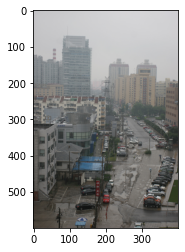

In [19]:
def dark_channel(kernel_size):
    b,g,r = cv2.split(image)
    dark_channel = cv2.min(cv2.min(r,g),b)
    s = (kernel_size, kernel_size)
    kernel = np.ones(s).astype(int)
    res = cv2.erode(dark_channel,kernel)
    plt.imshow(res)
    return res
image = plt.imread('haze.png')       
plt.imshow(image)

## Slider for dark channel

In [20]:
slider = interact(dark_channel, kernel_size=widgets.IntSlider(min=1,max=30,step=2,value=1))

interactive(children=(IntSlider(value=1, description='kernel_size', max=30, min=1, step=2), Output()), _dom_cl…

In [22]:
def dark_channel(image,kernel_size):
    b,g,r = cv2.split(image)
    dark_channel = cv2.min(cv2.min(r,g),b)
    s = (kernel_size, kernel_size)
    kernel = np.ones(s).astype(int)
    res = cv2.erode(dark_channel,kernel)
    return res
dark = dark_channel(image, 15)

In [23]:
def Atmospheric_light(img,dark):
    size = img.shape[0]*img.shape[1]
    zeroonepercent = int(max(math.floor(size/1000),1))
    darkvec = dark.reshape(size,1)
    imgvec = img.reshape(size,3)
    indices = darkvec.argsort()
    indices = indices[size-zeroonepercent::]
    Ac = np.zeros([1,3])
    for i in range(1,zeroonepercent):
        Ac = Ac + imgvec[indices[i]]
    Ac = Ac / zeroonepercent;
    return Ac

In [24]:
def transmission_map(img,atm,kernel_size,omega):
    im_array = np.zeros(img.shape,img.dtype)
    for i in range(0,3):
        im_array[:,:,i] = img[:,:,i]/atm[0,i]
    t = 1 - omega*dark_channel(im_array,kernel_size)
    return t

In [25]:
atm = Atmospheric_light(image, dark)

In [26]:
transmission_est = transmission_map(image,atm,15,0.75)

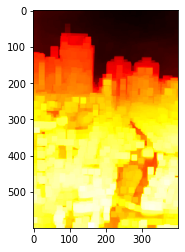

In [27]:
plt.imshow(transmission_est, cmap = 'hot')

## Let's do a slider

In [28]:
def transmission_map(kernel_size,omega):
    im_array = np.zeros(image.shape,image.dtype)
    for i in range(0,3):
        im_array[:,:,i] = image[:,:,i]/atm[0,i]
    t = 1 - omega*dark_channel(im_array,kernel_size)
    plt.imshow(t, cmap='hot')
    return t

In [29]:
interact(transmission_map, kernel_size=widgets.IntSlider(min=1,max=30,step=2,value=1), omega = 0.75)

interactive(children=(IntSlider(value=1, description='kernel_size', max=30, min=1, step=2), FloatSlider(value=…

<function __main__.transmission_map(kernel_size, omega)>

## Slider of guided filter for transmission map (фильтр для светопередачи)

In [30]:
def guideFilter(I, p, r, eps):
    mean_I = cv2.blur(I, (r,r))
    mean_p = cv2.blur(p, (r,r))
    mean_II = cv2.blur(I*I, (r,r))
    mean_Ip = cv2.blur(I*p, (r,r))
    var_I = mean_II - mean_I * mean_I
    cov_Ip = mean_Ip - mean_I * mean_p
    a = cov_Ip / (var_I + eps)
    b = mean_p - a*mean_I
    mean_a = cv2.blur(a, (r,r))
    mean_b = cv2.blur(b, (r,r)) 
    q = mean_a*I + mean_b
    return q

In [31]:
def transmission_map(img,atm,kernel_size,omega):
    im_array = np.zeros(img.shape,img.dtype)
    for i in range(0,3):
        im_array[:,:,i] = img[:,:,i]/atm[0,i]
    t = 1 - omega*dark_channel(im_array,kernel_size)
    return t

In [32]:
trans = transmission_map(image,atm,15, 0.65)

In [33]:
def TransmissionRefine(r, eps):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    gray = np.float64(gray)/255
    t = guideFilter(gray,trans,r,eps)
    plt.imshow(t)
    return t

In [34]:
s = interact(TransmissionRefine, r=widgets.IntSlider(min=1,max=30,step=2,value=1), eps = widgets.SelectionSlider(options=[1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 1e-02, 1e-03, 1e-04, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-010, 1e-011, 1e-012, 1e-013]))

interactive(children=(IntSlider(value=1, description='r', max=30, min=1, step=2), SelectionSlider(description=…

In [35]:
#4.3. Recovering the Scene Radiance
#A typical value of t0 is 0.1
def unhaze(img,t,A,t0 = 0.1):
    new_img = np.empty(img.shape,img.dtype)
    t = cv2.max(t,t0)
    for i in range(0,3):
        new_img[:,:,i] = (img[:,:,i]-A[0,i])/t + A[0,i]
    return new_img

In [36]:
def bgr2rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
def TransmissionRefine(img, trans, r, eps):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = np.float64(gray)/255
    t = guideFilter(gray,trans,r,eps)
    return t

In [37]:
#Let's rewrite accurately all functions bcs we rewrited them multiple time
def dark_channel(image,kernel_size):
    b,g,r = cv2.split(image)
    dark_channel = cv2.min(cv2.min(r,g),b)
    s = (kernel_size, kernel_size)
    kernel = np.ones(s).astype(int)
    res = cv2.erode(dark_channel,kernel)
    return res
def Atmospheric_light(img,dark):
    size = img.shape[0]*img.shape[1]
    zeroonepercent = int(max(math.floor(size/1000),1))
    darkvec = dark.reshape(size,1)
    imgvec = img.reshape(size,3)
    indices = darkvec.argsort()
    indices = indices[size-zeroonepercent::]
    Ac = np.zeros([1,3])
    for i in range(1,zeroonepercent):
        Ac = Ac + imgvec[indices[i]]
    Ac = Ac / zeroonepercent;
    return Ac
def transmission_map(img,atm,kernel_size,omega):
    im_array = np.zeros(img.shape,img.dtype)
    for i in range(0,3):
        im_array[:,:,i] = img[:,:,i]/atm[0,i]
    t = 1 - omega*dark_channel(im_array,kernel_size)
    return t
def guideFilter(I, p, r, eps):
    mean_I = cv2.blur(I, (r,r))
    mean_p = cv2.blur(p, (r,r))
    mean_II = cv2.blur(I*I, (r,r))
    mean_Ip = cv2.blur(I*p, (r,r))
    var_I = mean_II - mean_I * mean_I 
    cov_Ip = mean_Ip - mean_I * mean_p   
    a = cov_Ip / (var_I + eps)
    b = mean_p - a*mean_I
    mean_a = cv2.blur(a, (r,r))
    mean_b = cv2.blur(b, (r,r))
    q = mean_a*I + mean_b
    return q
def TransmissionRefine(img,transmission_est, r, eps):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = np.float64(gray)/255
    t = guideFilter(gray,transmission_est,r,eps)
    return t
def unhaze(img,t,A,t0 = 0.1):
    new_img = np.empty(img.shape,img.dtype)
    t = cv2.max(t,t0)
    for i in range(0,3):
        new_img[:,:,i] = (img[:,:,i]-A[0,i])/t + A[0,i]
    return new_img

In [38]:
image = cv2.imread('haze.png')

In [39]:
def dehaze(kernel_dark, kernel_transmission, omega, r, eps):
    img = bgr2rgb(image)
    I = img.astype('float64')/255
    dark = dark_channel(I,kernel_dark)
    A = Atmospheric_light(I,dark)
    te = transmission_map(I,A,kernel_transmission, omega)
    t = TransmissionRefine(img,te, r, eps)
    J = unhaze(I,t,A,0.1)
    plt.imshow(J)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


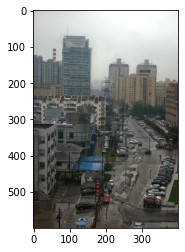

In [40]:
#Стандартные параметры
dehaze(15,15,0.65,15,0.0000001)

In [154]:
#Решение со слайдерами

In [41]:
interact(dehaze, kernel_dark=widgets.IntSlider(min=1,max=30,step=2,value=1), kernel_transmission=widgets.IntSlider(min=1,max=30,step=2,value=1), omega = 0.75, r=widgets.IntSlider(min=1,max=100,step=2,value=1), 
eps = widgets.SelectionSlider(options=[1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 1e-02, 1e-03, 1e-04, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-010, 1e-011, 1e-012, 1e-013]))



interactive(children=(IntSlider(value=1, description='kernel_dark', max=30, min=1, step=2), IntSlider(value=1,…

<function __main__.dehaze(kernel_dark, kernel_transmission, omega, r, eps)>

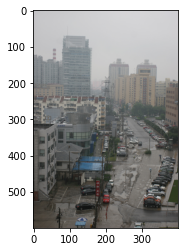

In [42]:
#Вспомним картинку до
im = bgr2rgb(image)
plt.imshow(im)

In [43]:
image = cv2.imread('china.png')

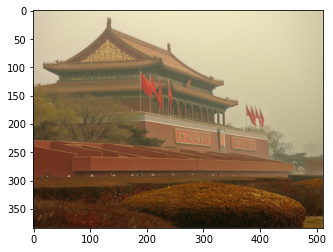

In [44]:
#Стандартные параметры
dehaze(15,15,0.65,15,0.0000001)

In [45]:
interact(dehaze, kernel_dark=widgets.IntSlider(min=1,max=30,step=2,value=1), kernel_transmission=widgets.IntSlider(min=1,max=30,step=2,value=1), omega = 0.75, r=widgets.IntSlider(min=1,max=100,step=2,value=1), 
eps = widgets.SelectionSlider(options=[1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 1e-02, 1e-03, 1e-04, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-010, 1e-011, 1e-012, 1e-013]))



interactive(children=(IntSlider(value=1, description='kernel_dark', max=30, min=1, step=2), IntSlider(value=1,…

<function __main__.dehaze(kernel_dark, kernel_transmission, omega, r, eps)>

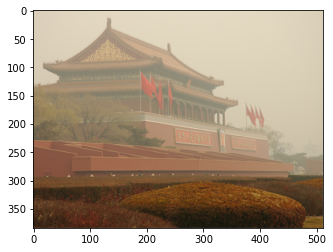

In [46]:
#Вспомним картинку до
im = bgr2rgb(image)
plt.imshow(im)

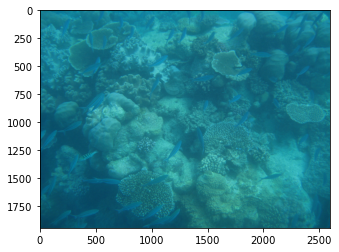

In [56]:
image = cv2.imread('underwater.jpg')
image = bgr2rgb(image)
plt.imshow(image)

In [57]:
interact(dehaze, kernel_dark=widgets.IntSlider(min=1,max=30,step=2,value=1), kernel_transmission=widgets.IntSlider(min=1,max=30,step=2,value=1), omega = 0.75, r=widgets.IntSlider(min=1,max=100,step=2,value=1), 
eps = widgets.SelectionSlider(options=[1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 1e-02, 1e-03, 1e-04, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-010, 1e-011, 1e-012, 1e-013]))



interactive(children=(IntSlider(value=1, description='kernel_dark', max=30, min=1, step=2), IntSlider(value=1,…

<function __main__.dehaze(kernel_dark, kernel_transmission, omega, r, eps)>